# *** THIS PROJECT IS A COLLABORATION BETWEEN BLESSING NWOGU, DIANA CASTILLO, GILA KOHANBASH, AND RACHEL FINLEY ***

In [39]:
!pip install xgboost

     --------------------------------------- 70.9/70.9 MB 26.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_regression

### Using TFIDF, then truncating results, then combing datasets, and running GB Regressor

In [67]:
train_df = pd.read_csv("checkpoint_train.csv")
test_df = pd.read_csv("checkpoint_test.csv")    

In [7]:
text_columns = ['overview', 'tagline', 'title', 'all_keywords']

In [69]:
num_train = train_df.drop(columns = text_columns)
num_test = test_df.drop(columns = text_columns)

In [70]:
train_df[text_columns].head(1)

,overview,tagline,title,all_keywords
0,Karl Childers is a mentally disabled man who h...,A simple man A difficult choice,Sling Blade,independent film repair shop southern death th...


In [71]:
train_df[text_columns] = train_df[text_columns].fillna("").astype(str)
test_df[text_columns] = test_df[text_columns].fillna("").astype(str)

In [72]:
train_df['combined_text'] = train_df['overview'] + train_df['tagline'] + train_df['title'] + train_df['all_keywords']
test_df['combined_text'] = test_df['overview'] + test_df['tagline'] + test_df['title'] + test_df['all_keywords']

In [73]:
test_df['combined_text'][0]

'Uncle Fester has been missing for 25 years An evil doctor finds out and introduces a fake Fester in an attempt to get the Adams Familys money The youngest daughter has some doubts about the new uncle Fester but the fake uncle adapts very well to the strange family Can the doctor carry out her evil plans and take over the Adams Familys fortune?Weird Is RelativeThe Addams Familydead wish vampire black humor uncle eccentric werewolf macabre loan shark accountant'

In [74]:
vectorizer = TfidfVectorizer()
vectorizer.fit(train_df['combined_text'])
tfidf_train_matrix = vectorizer.transform(train_df['combined_text'])
tfidf_test_matrix = vectorizer.transform(test_df['combined_text'])

- would be interesting to try different 'n_components' values. it is the amount of columns that the tfidf matrix will truncate into

In [75]:
svd_model = TruncatedSVD(n_components = 4)
svd_matrix_train = svd_model.fit_transform(tfidf_train_matrix)
svd_matrix_test = svd_model.fit_transform(tfidf_test_matrix)

In [76]:
train_df = pd.merge(num_train, pd.DataFrame(svd_matrix_train), left_index = True, right_index = True)
test_df = pd.merge(num_test, pd.DataFrame(svd_matrix_test), left_index = True, right_index = True)

In [77]:
X_train = train_df.drop(labels = 'rating', axis = 1)
y_train = train_df['rating']

X_test = test_df

In [52]:
X_train.head(1)

,userId,movieId,budget,popularity,release_date,revenue,runtime,vote_average,vote_count,part_of_collection,...,Mystery,War,Documentary,History,high_revenue,low_revenue,0,1,2,3
0,10,1358,1000000.0,8.46,1996,24444121.0,135,7.4,109,0,...,0,0,0,0,False,False,0.192147,-0.020873,0.014382,0.060152


In [53]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'n_estimators': 100
}

In [54]:
xgb_model = xgb.XGBRegressor(**params)

In [55]:
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [56]:
test_df['rating'] = xgb_model.predict(X_test)
test_df['movieId'] = test_df['movieId'].astype(int).astype (str)
test_df['userId']= test_df['userId'].astype(int).astype (str)
test_df['userId_movieId'] = test_df['userId'] + '_' + test_df['movieId']
cols = ['userId_movieId', 'rating']
test_df = test_df[cols]

In [58]:
test_df.to_csv('submission_tfidf_svdtrunc_xgboost.csv', index = False)

Model RMSE: 0.1873

In [63]:
# Define the hyperparameters to be tuned and their respective values
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'max_bin': [32, 64, 128],
    'tree_method': ['auto', 'exact', 'approx']
}

In [64]:
# Train the XGBoost model using GridSearchCV to find the best hyperparameters
xgb_model = xgb.XGBRegressor()
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=N

In [65]:
best_params = grid_search.best_params_
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=32,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [80]:
grid_search.best_params_

{'learning_rate': 0.2,
 'max_bin': 32,
 'max_depth': 7,
 'n_estimators': 150,
 'tree_method': 'auto'}

In [78]:
test_df['rating'] = xgb_model.predict(X_test)
test_df['movieId'] = test_df['movieId'].astype(int).astype (str)
test_df['userId']= test_df['userId'].astype(int).astype (str)
test_df['userId_movieId'] = test_df['userId'] + '_' + test_df['movieId']
cols = ['userId_movieId', 'rating']
test_df = test_df[cols]

In [79]:
test_df.to_csv('submission_tfidf_svdtrunc_xgboost_tuned.csv', index = False)

model RMSE: 0.1767

#### Theory: The overviews of the films are adding unnessecary noise to the dataset, so try doing this all again with best params and just doing tfidf for keywords

In [98]:
train_df = pd.read_csv("checkpoint_train.csv")
test_df = pd.read_csv("checkpoint_test.csv")    

In [99]:
text_columns = ['overview', 'tagline', 'title', 'all_keywords']

In [100]:
num_train = train_df.drop(columns = text_columns)
num_test = test_df.drop(columns = text_columns)

In [101]:
train_df[text_columns] = train_df[text_columns].fillna("").astype(str)
test_df[text_columns] = test_df[text_columns].fillna("").astype(str)

In [102]:
vectorizer = TfidfVectorizer()
vectorizer.fit(train_df['all_keywords'])
tfidf_train_matrix = vectorizer.transform(train_df['all_keywords'])
tfidf_test_matrix = vectorizer.transform(test_df['all_keywords'])

In [103]:
svd_model = TruncatedSVD(n_components = 1)
svd_matrix_train = svd_model.fit_transform(tfidf_train_matrix)
svd_matrix_test = svd_model.fit_transform(tfidf_test_matrix)

In [104]:
train_df = pd.merge(num_train, pd.DataFrame(svd_matrix_train), left_index = True, right_index = True)
test_df = pd.merge(num_test, pd.DataFrame(svd_matrix_test), left_index = True, right_index = True)

In [105]:
X_train = train_df.drop(labels = 'rating', axis = 1)
y_train = train_df['rating']

X_test = test_df

In [106]:
params = {'learning_rate': 0.2,
         'max_bin': 32,
         'max_depth': 7,
         'n_estimators': 150,
         'tree_method': 'auto'}

In [107]:
xgb_model = xgb.XGBRegressor(**params)

In [108]:
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=32,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [109]:
test_df['rating'] = xgb_model.predict(X_test)
test_df['movieId'] = test_df['movieId'].astype(int).astype (str)
test_df['userId']= test_df['userId'].astype(int).astype (str)
test_df['userId_movieId'] = test_df['userId'] + '_' + test_df['movieId']
cols = ['userId_movieId', 'rating']
test_df = test_df[cols]

In [110]:
test_df.to_csv('submission_tfidf_justkeywords_svdtrunc_xgboost_tuned_2.csv', index = False)

Model RMSE: 0.1757

#### Next, let's try just not using the text data at all and seeing how it compares?

In [111]:
train_df = pd.read_csv("checkpoint_train.csv")
test_df = pd.read_csv("checkpoint_test.csv")    

In [112]:
train_df.drop(columns = text_columns, inplace = True)
test_df.drop(columns = text_columns, inplace = True)

In [113]:
train_df.head(2)

,rating,userId,movieId,budget,popularity,release_date,revenue,runtime,vote_average,vote_count,...,Adventure,Romance,Family,TV Movie,Mystery,War,Documentary,History,high_revenue,low_revenue
0,0.4,10,1358,1000000.00,8.46,1996,24444121.00,135,7.4,109,...,0,0,0,0,0,0,0,0,False,False
1,0.7,237,1544,15652992.07,0.79,1997,31950070.07,129,6.2,109,...,0,0,0,0,0,0,0,0,True,False


In [114]:
X_train = train_df.drop(labels = 'rating', axis = 1)
y_train = train_df['rating']

X_test = test_df

In [3]:
params = {'learning_rate': 0.2,
         'max_bin': 32,
         'max_depth': 7,
         'n_estimators': 150,
         'tree_method': 'auto'}

In [116]:
xgb_model = xgb.XGBRegressor(**params)

In [117]:
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=32,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [118]:
test_df['rating'] = xgb_model.predict(X_test)
test_df['movieId'] = test_df['movieId'].astype(int).astype (str)
test_df['userId']= test_df['userId'].astype(int).astype (str)
test_df['userId_movieId'] = test_df['userId'] + '_' + test_df['movieId']
cols = ['userId_movieId', 'rating']
test_df = test_df[cols]

In [120]:
test_df.to_csv('submission_xgboost_tuned.csv', index = False)

Model RMSE: 0.174

In [121]:
from xgboost import plot_importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

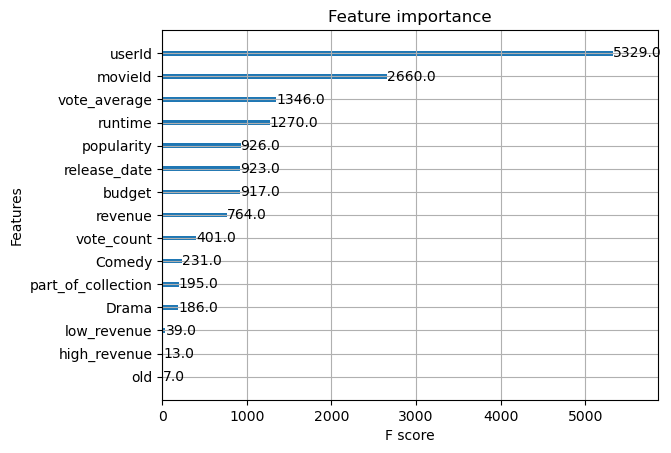

In [122]:
plot_importance(xgb_model)

#### Feaature selection, and further hyperparam tuning on smaller feature set

In [1]:
from sklearn.feature_selection import RFE

In [22]:
train_df = pd.read_csv("checkpoint_train.csv")
test_df = pd.read_csv("checkpoint_test.csv")    

In [8]:
train_df.drop(columns = text_columns, inplace = True)
test_df.drop(columns = text_columns, inplace = True)

In [9]:
X_train = train_df.drop(labels = 'rating', axis = 1)
y_train = train_df['rating']

X_test = test_df

In [10]:
# Create RFE object
rfe = RFE(estimator = model)

# Create parameter grid for RFE hyperparameters
rfe_param_grid = {
    'n_features_to_select': [5, 10, 15],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__n_estimators': [50, 100, 200]
}

In [11]:
# Perform grid search with cross-validation for RFE hyperparameters
rfe_grid_search = GridSearchCV(estimator = rfe, param_grid = rfe_param_grid, cv = 5, n_jobs = -1)
rfe_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RFE(estimator=XGBRegressor(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  gamma=None, gpu_id=None,
                                                  grow_policy=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
                           

In [12]:
# Get best RFE parameters and transform training and testing data
rfe_best_params = rfe_grid_search.best_params_
rfe.set_params(**rfe_best_params)
rfe.fit(X_train, y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [4]:
# Create XGB Regressor object
model = xgb.XGBRegressor(**params)

# Create parameter grid for XGBoost hyperparameters
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

In [13]:
# Perform grid search with cross-validation for XGBoost hyperparameters
xgb_grid_search = GridSearchCV(estimator = model, param_grid = xgb_param_grid, cv = 5, n_jobs = -1)
xgb_grid_search.fit(X_train_rfe, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.2, ma...=32,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=7, max_leaves=None,
                                    min_child_weight=None, missing=nan,
         

In [14]:
# Get best XGBoost parameters and train final model
xgb_best_params = xgb_grid_search.best_params_
model.set_params(**xgb_best_params)
model.fit(X_train_rfe, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=32,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [16]:
test_df['rating'] = model.predict(X_test_rfe)
test_df['movieId'] = test_df['movieId'].astype(int).astype (str)
test_df['userId']= test_df['userId'].astype(int).astype (str)
test_df['userId_movieId'] = test_df['userId'] + '_' + test_df['movieId']
cols = ['userId_movieId', 'rating']
test_df = test_df[cols]

In [17]:
test_df.to_csv('submission_feature_selection_xgboost_tuned.csv', index = False)

Model RMSE: .1734

# Ideas: 
- ## try more specific hyperparams with the XGBoost feature selection
- ## try adding text data and svd trunc, then doing the feature selection
- ## try doing the cosine distance feature grid with the genres or keywords and then truncing

#### Try doing another expiriment with RFE, but trying just different "n_features"

In [10]:
from sklearn.feature_selection import RFE

In [33]:
train_df = pd.read_csv("checkpoint_train.csv")
test_df = pd.read_csv("checkpoint_test.csv")    

In [34]:
train_df.drop(columns = text_columns, inplace = True)
test_df.drop(columns = text_columns, inplace = True)

In [35]:
X_train = train_df.drop(labels = 'rating', axis = 1)
y_train = train_df['rating']

X_test = test_df

In [36]:
print(rfe_grid_search.best_params_)

{'estimator__max_depth': None, 'estimator__n_estimators': 200, 'n_features_to_select': 5}


In [41]:
model = xgb.XGBRegressor(learning_rate = .2, max_depth = 7, n_estimators = 200)

In [42]:
# Create RFE object
rfe = RFE(estimator = model)

# Create parameter grid for RFE hyperparameters
rfe_param_grid = {
    'n_features_to_select': [4, 5, 6],
    'estimator__learning_rate': [0.2],
    'estimator__n_estimators': [200]
}

In [43]:
# Perform grid search with cross-validation for RFE hyperparameters
rfe_grid_search = GridSearchCV(estimator = rfe, param_grid = rfe_param_grid, cv = 5, n_jobs = -1)
rfe_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RFE(estimator=XGBRegressor(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  gamma=None, gpu_id=None,
                                                  grow_policy=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
                           

In [52]:
print(rfe_grid_search.best_params_)

{'estimator__learning_rate': 0.2, 'estimator__n_estimators': 200, 'n_features_to_select': 6}


In [44]:
# Get best RFE parameters and transform training and testing data
rfe_best_params = rfe_grid_search.best_params_
rfe.set_params(**rfe_best_params)
rfe.fit(X_train, y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [46]:
model = xgb.XGBRegressor(learning_rate = .2, max_depth = 7, n_estimators = 200)

# Create parameter grid for XGBoost hyperparameters
xgb_param_grid = {
    'learning_rate': [0.2],
    'n_estimators': [190, 200, 210],
    'max_depth': [7]
}

In [47]:
# Perform grid search with cross-validation for XGBoost hyperparameters
xgb_grid_search = GridSearchCV(estimator = model, param_grid = xgb_param_grid, cv = 5, n_jobs = -1)
xgb_grid_search.fit(X_train_rfe, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.2, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=7, max_leaves=None,
                                    min_child_weight=None, missing=nan,
     

In [48]:
print(xgb_grid_search.best_params_)

{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 210}


In [49]:
# Get best XGBoost parameters and train final model
xgb_best_params = xgb_grid_search.best_params_
model.set_params(**xgb_best_params)
model.fit(X_train_rfe, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=210, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [50]:
test_df['rating'] = model.predict(X_test_rfe)
test_df['movieId'] = test_df['movieId'].astype(int).astype (str)
test_df['userId']= test_df['userId'].astype(int).astype (str)
test_df['userId_movieId'] = test_df['userId'] + '_' + test_df['movieId']
cols = ['userId_movieId', 'rating']
test_df = test_df[cols]

In [51]:
test_df.to_csv('submission_feature_selection_xgboost_tuned_2.csv', index = False)

Model RMSE: 0.1731


#### FURTHER TUNING

In [53]:
train_df = pd.read_csv("checkpoint_train.csv")
test_df = pd.read_csv("checkpoint_test.csv")    

In [54]:
train_df.drop(columns = text_columns, inplace = True)
test_df.drop(columns = text_columns, inplace = True)

In [55]:
X_train = train_df.drop(labels = 'rating', axis = 1)
y_train = train_df['rating']

X_test = test_df

In [56]:
print(rfe_grid_search.best_params_)

{'estimator__learning_rate': 0.2, 'estimator__n_estimators': 200, 'n_features_to_select': 6}


In [57]:
model = xgb.XGBRegressor(learning_rate = .2, max_depth = 7, n_estimators = 210)

In [58]:
# Create RFE object
rfe = RFE(estimator = model)

# Create parameter grid for RFE hyperparameters
rfe_param_grid = {
    'n_features_to_select': [6, 7, 8],
    'estimator__learning_rate': [0.2],
    'estimator__n_estimators': [200]
}

In [59]:
# Perform grid search with cross-validation for RFE hyperparameters
rfe_grid_search = GridSearchCV(estimator = rfe, param_grid = rfe_param_grid, cv = 5, n_jobs = -1)
rfe_grid_search.fit(X_train, y_train)
print(rfe_grid_search.best_params_)

GridSearchCV(cv=5,
             estimator=RFE(estimator=XGBRegressor(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  gamma=None, gpu_id=None,
                                                  grow_policy=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
                           

In [60]:
print(rfe_grid_search.best_params_)

{'estimator__learning_rate': 0.2, 'estimator__n_estimators': 200, 'n_features_to_select': 7}


In [61]:
# Get best RFE parameters and transform training and testing data
rfe_best_params = rfe_grid_search.best_params_
rfe.set_params(**rfe_best_params)
rfe.fit(X_train, y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [62]:
print(xgb_grid_search.best_params_)

{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 210}


In [63]:
model = xgb.XGBRegressor(learning_rate = .2, max_depth = 7, n_estimators = 200)

# Create parameter grid for XGBoost hyperparameters
xgb_param_grid = {
    'learning_rate': [0.2],
    'n_estimators': [210, 220, 250],
    'max_depth': [7]
}

In [64]:
# Perform grid search with cross-validation for XGBoost hyperparameters
xgb_grid_search = GridSearchCV(estimator = model, param_grid = xgb_param_grid, cv = 5, n_jobs = -1)
xgb_grid_search.fit(X_train_rfe, y_train)
print(xgb_grid_search.best_params_)

{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 210}


In [65]:
print(xgb_grid_search.best_params_)

{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 210}


In [66]:
# Get best XGBoost parameters and train final model
xgb_best_params = xgb_grid_search.best_params_
model.set_params(**xgb_best_params)
model.fit(X_train_rfe, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=210, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [67]:
test_df['rating'] = model.predict(X_test_rfe)
test_df['movieId'] = test_df['movieId'].astype(int).astype (str)
test_df['userId']= test_df['userId'].astype(int).astype (str)
test_df['userId_movieId'] = test_df['userId'] + '_' + test_df['movieId']
cols = ['userId_movieId', 'rating']
test_df = test_df[cols]

In [68]:
test_df.to_csv('submission_feature_selection_xgboost_tuned_3.csv', index = False)

#### Even more tuning!

In [70]:
train_df = pd.read_csv("checkpoint_train.csv")
test_df = pd.read_csv("checkpoint_test.csv")    

In [71]:
train_df.drop(columns = text_columns, inplace = True)
test_df.drop(columns = text_columns, inplace = True)

In [72]:
X_train = train_df.drop(labels = 'rating', axis = 1)
y_train = train_df['rating']

X_test = test_df

In [73]:
rfe_params = {'estimator__learning_rate': 0.2,
              'estimator__n_estimators': 200, 
              'n_features_to_select': 7}

In [74]:
rfe.set_params(**rfe_params)
rfe.fit(X_train, y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [75]:
print(xgb_grid_search.best_params_)

{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 210}


In [76]:
model = xgb.XGBRegressor(random_state = 42, verbosity = 1)

# Create parameter grid for XGBoost hyperparameters
xgb_param_grid = {
    'learning_rate': [0.2],
    'n_estimators': [210],
    'max_depth': [7, 8, 9],
    'gamma': [0.05, 0.5],
    'scale_pos_weight': [0, 1],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [1, 0],
    'objective': ['reg:squarederror']
}

In [77]:
# Perform grid search with cross-validation for XGBoost hyperparameters
xgb_grid_search = GridSearchCV(estimator = model, param_grid = xgb_param_grid, cv = 5, n_jobs = -1,  scoring = 'neg_root_mean_squared_error')
xgb_grid_search.fit(X_train_rfe, y_train)
print(xgb_grid_search.best_params_)

{'gamma': 0.05, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 210, 'objective': 'reg:squarederror', 'reg_alpha': 0.5, 'reg_lambda': 0, 'scale_pos_weight': 1}


In [78]:
# Get best XGBoost parameters and train final model
xgb_best_params = xgb_grid_search.best_params_
model.set_params(**xgb_best_params)
model.fit(X_train_rfe, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.05, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=210, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [79]:
test_df['rating'] = model.predict(X_test_rfe)
test_df['movieId'] = test_df['movieId'].astype(int).astype (str)
test_df['userId']= test_df['userId'].astype(int).astype (str)
test_df['userId_movieId'] = test_df['userId'] + '_' + test_df['movieId']
cols = ['userId_movieId', 'rating']
test_df = test_df[cols]

In [80]:
test_df.to_csv('submission_feature_selection_xgboost_tuned_4.csv', index = False)

Model RMSE: 0.1725

# More Expiriments. Just changing up n_components and n_features_to_select

In [3]:
train_df = pd.read_csv("checkpoint_train.csv")
test_df = pd.read_csv("checkpoint_test.csv")    

In [4]:
text_columns = ['overview', 'tagline', 'title', 'all_keywords']

In [5]:
num_train = train_df.drop(columns = text_columns)
num_test = test_df.drop(columns = text_columns)

In [6]:
train_df[text_columns] = train_df[text_columns].fillna("").astype(str)
test_df[text_columns] = test_df[text_columns].fillna("").astype(str)

In [7]:
vectorizer = TfidfVectorizer()
vectorizer.fit(train_df['all_keywords'])
tfidf_train_matrix = vectorizer.transform(train_df['all_keywords'])
tfidf_test_matrix = vectorizer.transform(test_df['all_keywords'])

In [8]:
svd_model = TruncatedSVD(n_components = 13)
svd_matrix_train = svd_model.fit_transform(tfidf_train_matrix)
svd_matrix_test = svd_model.fit_transform(tfidf_test_matrix)

In [9]:
train_df = pd.merge(num_train, pd.DataFrame(svd_matrix_train), left_index = True, right_index = True)
test_df = pd.merge(num_test, pd.DataFrame(svd_matrix_test), left_index = True, right_index = True)

In [10]:
X_train = train_df.drop(labels = 'rating', axis = 1)
y_train = train_df['rating']

X_test = test_df

In [11]:
rfe_params = {'estimator__learning_rate': 0.2,
              'estimator__n_estimators': 200, 
              'n_features_to_select': 13}

In [15]:
xgb_params = {'gamma': 0.05, 
              'learning_rate': 0.2, 
              'max_depth': 7, 
              'n_estimators': 210, 
              'objective': 'reg:squarederror', 
              'reg_alpha': 0.5, 
              'reg_lambda': 0, 
              'scale_pos_weight': 1}

In [16]:
model = xgb.XGBRegressor(**xgb_params, random_state = 42, verbosity = 1)


In [18]:
rfe = RFE(estimator = model)
rfe.set_params(**rfe_params)
rfe.fit(X_train, y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

C:\Users\rache\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\rache\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\rache\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [19]:
model.fit(X_train_rfe, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.05, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [20]:
test_df['rating'] = model.predict(X_test_rfe)
test_df['movieId'] = test_df['movieId'].astype(int).astype (str)
test_df['userId']= test_df['userId'].astype(int).astype (str)
test_df['userId_movieId'] = test_df['userId'] + '_' + test_df['movieId']
cols = ['userId_movieId', 'rating']
test_df = test_df[cols]

In [22]:
test_df.to_csv('submission_feature_selection_xgboost_tuned_5_plus_tfidf_truncd_features.csv', index = False)

Model RMSE: .1725

# More Expiriments. Using data from stacking_regressors.

In [28]:
train_df = pd.read_csv("train_checkpoint.csv")
test_df = pd.read_csv("test_checkpoint.csv")    

In [29]:
train_df.shape

(70002, 36)

In [30]:
test_df.shape

(30002, 35)

In [31]:
X_train = train_df.drop(labels = 'rating', axis = 1)
y_train = train_df['rating']

X_test = test_df

In [32]:
rfe_params = {'estimator__learning_rate': 0.2,
              'estimator__n_estimators': 200, 
              'n_features_to_select': 13}

In [33]:
xgb_params = {'gamma': 0.05, 
              'learning_rate': 0.2, 
              'max_depth': 7, 
              'n_estimators': 210, 
              'objective': 'reg:squarederror', 
              'reg_alpha': 0.5, 
              'reg_lambda': 0, 
              'scale_pos_weight': 1}

In [34]:
model = xgb.XGBRegressor(**xgb_params, random_state = 42, verbosity = 1)


In [35]:
rfe = RFE(estimator = model)
rfe.set_params(**rfe_params)
rfe.fit(X_train, y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [36]:
model.fit(X_train_rfe, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.05, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [37]:
test_df['rating'] = model.predict(X_test_rfe)
test_df['movieId'] = test_df['movieId'].astype(int).astype (str)
test_df['userId']= test_df['userId'].astype(int).astype (str)
test_df['userId_movieId'] = test_df['userId'] + '_' + test_df['movieId']
cols = ['userId_movieId', 'rating']
test_df = test_df[cols]

In [38]:
test_df = test_df.drop_duplicates()

In [39]:
test_df.shape

(30002, 2)

In [40]:
test_df.to_csv('expiriment_xgboost_new_feature_engineering.csv', index = False)

Model RMSE: .173

#### FURTHER TUNING

In [120]:
train_df = pd.read_csv("train_checkpoint.csv")
test_df = pd.read_csv("test_checkpoint.csv")    

In [121]:
X_train = train_df.drop(labels = 'rating', axis = 1)
y_train = train_df['rating']

X_test = test_df

In [122]:
xgb_params = {'gamma': 0.05, 
              'learning_rate': 0.2, 
              'max_depth': 7, 
              'n_estimators': 900, 
              'objective': 'reg:squarederror', 
              'reg_alpha': 0.5, 
              'reg_lambda': 0, 
              'scale_pos_weight': 1}

In [123]:
model = xgb.XGBRegressor(**xgb_params)

In [124]:
# Create RFE object
rfe = RFE(estimator = model)

# Create parameter grid for RFE hyperparameters
rfe_param_grid = {
    'n_features_to_select': [7],
    'estimator__learning_rate': [0.2],
    'estimator__n_estimators': [200]
}

In [125]:
# Perform grid search with cross-validation for RFE hyperparameters
rfe_grid_search = GridSearchCV(estimator = rfe, param_grid = rfe_param_grid, cv = 5, n_jobs = -1)
rfe_grid_search.fit(X_train, y_train)
print(rfe_grid_search.best_params_)

{'estimator__learning_rate': 0.2, 'estimator__n_estimators': 200, 'n_features_to_select': 7}


In [126]:
print(rfe_grid_search.best_params_)

{'estimator__learning_rate': 0.2, 'estimator__n_estimators': 200, 'n_features_to_select': 7}


In [127]:
# Get best RFE parameters and transform training and testing data
rfe_best_params = rfe_grid_search.best_params_
rfe.set_params(**rfe_best_params)
rfe.fit(X_train, y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [128]:
model = xgb.XGBRegressor(learning_rate = .2)
 

# Create parameter grid for XGBoost hyperparameters
xgb_param_grid = {
    'gamma': [0.05],
    'learning_rate': [0.2],
    'n_estimators': [900],
    'max_depth': [5, 6, 7],
    'objective': ['reg:squarederror'], 
    'reg_alpha': [0.5], 
    'reg_lambda': [0], 
    'scale_pos_weight': [1]
}

In [129]:
# Perform grid search with cross-validation for XGBoost hyperparameters
xgb_grid_search = GridSearchCV(estimator = model, param_grid = xgb_param_grid, cv = 5, n_jobs = -1)
xgb_grid_search.fit(X_train_rfe, y_train)
print(xgb_grid_search.best_params_)

{'gamma': 0.05, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 900, 'objective': 'reg:squarederror', 'reg_alpha': 0.5, 'reg_lambda': 0, 'scale_pos_weight': 1}


In [130]:
# Get best XGBoost parameters and train final model
xgb_best_params = xgb_grid_search.best_params_
model.set_params(**xgb_best_params)
model.fit(X_train_rfe, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.05, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=900, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [131]:
test_df['rating'] = model.predict(X_test_rfe)
test_df['movieId'] = test_df['movieId'].astype(int).astype (str)
test_df['userId']= test_df['userId'].astype(int).astype (str)
test_df['userId_movieId'] = test_df['userId'] + '_' + test_df['movieId']
cols = ['userId_movieId', 'rating']
test_df = test_df[cols]

In [132]:
test_df.to_csv('expiriment_xgboost_new_feature_engineering_6.csv', index = False)